In [594]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import invgamma

In [595]:
#Données
r =[10, 23, 23, 26, 17, 5, 53, 55, 32, 46, 10, 8, 10, 8, 23, 0, 3, 22, 15, 32, 3]
n = [39, 62, 81, 51, 39, 6, 74, 72, 51, 79, 13, 16, 30, 28, 45, 4, 12, 41, 30, 51, 7]
x1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
x2 = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [596]:
#Fonctions utiles:
def sigm(x): #Fonction sigmoïde
    return 1/(1+np.exp(-x))
def p(alpha0,alpha1,x1,alpha2,x2,alpha12,b):
    return sigm(alpha0+alpha1*x1+alpha2*x2+alpha12*x1*x2+b)
def R(alpha0,alpha1,alpha2,alpha12,b): 
    a=0 #vraisemblance r
    for i in range(K):
        a += r[i]*np.log(p(alpha0,alpha1,x1[i],alpha2,x2[i],alpha12,b[i]))+(n[i]-r[i])*np.log(1-p(alpha0,alpha1,x1[i],alpha2,x2[i],alpha12,b[i]))
    return a
    
N=10000 #Nombre d'itérations de l'échantilloneur
K=21 #Nombre de "strates"

#Echantilloneur:
def GibbsSampler(N,std_dev,alpha0,alpha1,alpha2,alpha12,sigma,b):
    X=np.zeros((N+1,5)) # alpha0,alpha1,alpha2,alpha12,sigma
    Xb=np.zeros((N+1,K))
    #Initialisation
    X[0]=[alpha0,alpha1,alpha2,alpha12,sigma]
    Xb[0]=b

    for j in range(N):

        #Mise à jour alpha0
        X[j+1]=X[j]
        Xp=X[j+1][0]+std_dev[0]*np.random.normal() #proposition alpha0
        top0=-Xp**2/2000000 #loi a priori
        top1=R(Xp,X[j+1][1],X[j+1][2],X[j+1][3],Xb[j+1])
        top=top0+top1
        bottom0=-X[j+1][0]**2/2000000 #loi a priori
        bottom1=R(X[j+1][0],X[j+1][1],X[j+1][2],X[j+1][3],Xb[j+1]) #vraisemblance
        bottom=bottom0+bottom1
        prob=np.exp(top-bottom)
        if np.random.uniform()<prob:
            X[j+1][0]=Xp
        
        #Mise à jour alpha1
        Xp=X[j+1][1]+std_dev[1]*np.random.normal() #proposition alpha1
        top0=-Xp**2/2000000 #loi a priori
        top1=R(X[j+1][0],Xp,X[j+1][2],X[j+1][3],Xb[j+1])
        top=top0+top1
        bottom0=-X[j+1][1]**2/2000000 #loi a priori
        bottom1=R(X[j+1][0],X[j+1][1],X[j+1][2],X[j+1][3],Xb[j+1]) #vraisemblance
        bottom=bottom0+bottom1
        prob=np.exp(top-bottom)
        if np.random.uniform()<prob:
            X[j+1][1]=Xp

        #Mise à jour alpha2
        Xp=X[j+1][2]+std_dev[2]*np.random.normal() #proposition alpha2
        top0=-Xp**2/2000000 #loi a priori
        top1=R(X[j+1][0],X[j+1][1],Xp,X[j+1][3],Xb[j+1])
        top=top0+top1
        bottom0=-X[j+1][2]**2/2000000 #loi a priori
        bottom1=R(X[j+1][0],X[j+1][1],X[j+1][2],X[j+1][3],Xb[j+1]) #vraisemblance
        bottom=bottom0+bottom1
        prob=np.exp(top-bottom)
        if np.random.uniform()<prob:
            X[j+1][2]=Xp

        #Mise à jour alpha12
        Xp=X[j+1][3]+std_dev[3]*np.random.normal() #proposition alpha12
        top0=-Xp**2/2000000 #loi a priori
        top1=R(X[j+1][0],X[j+1][1],X[j+1][2],Xp,Xb[j+1])
        top=top0+top1
        bottom0=-X[j+1][3]**2/2000000 #loi a priori
        bottom1=R(X[j+1][0],X[j+1][1],X[j+1][2],X[j+1][3],Xb[j+1]) #vraisemblance
        bottom=bottom0+bottom1
        prob=np.exp(top-bottom)
        if np.random.uniform()<prob:
            X[j+1][3]=Xp
        
        #Mise à jour sigma
        tau=np.random.gamma(0.001+K/2,1/(0.001+np.sum(Xb[j+1]**2)/2))
        X[j+1][4]=1/np.sqrt(tau)
        
        #Mise à jour b
        Xb[j+1]=Xb[j]
        for i in range(K):
            Xp=Xb[j+1][i]+std_dev[4]*np.random.normal() #proposition b
            top0=-Xp**2/(2*X[j+1][4]**2) #loi a priori b
            top1=r[i]*np.log(p(X[j+1][0],X[j+1][1],x1[i],X[j+1][2],x2[i],X[j+1][3],Xp))+(n[i]-r[i])*np.log(1-p(X[j+1][0],X[j+1][1],x1[i],X[j+1][2],x2[i],X[j+1][3],Xp))
            top=top0+top1
            bottom0=-Xb[j+1][i]**2/(2*X[j+1][4]**2) #loi a priori b
            bottom1=r[i]*np.log(p(X[j+1][0],X[j+1][1],x1[i],X[j+1][2],x2[i],X[j+1][3],Xb[j+1][i]))+(n[i]-r[i])*np.log(1-p(X[j+1][0],X[j+1][1],x1[i],X[j+1][2],x2[i],X[j+1][3],Xb[j+1][i]))
            bottom=bottom0+bottom1
            prob=np.exp(top-bottom)
            if np.random.uniform()<prob:
                Xb[j+1][i]=Xp
    return X,Xb

In [597]:
std_dev=[0.5,0.5,0.5,0.5,0.01] #Variance des propositions (ajustées)

#Valeurs initiales (ajustées):
alpha0=-0.5
alpha1=0.1
alpha2=1.3
alpha12=-0.7
b=[0]*K
sigma=0.01
N=10000
t0=time.time()
X,Xb=GibbsSampler(N,std_dev,alpha0,alpha1,alpha2,alpha12,sigma,b)
print(f"temps d'éxécution pour n={N}: {time.time()-t0} s.")

temps d'éxécution pour n=10000: 65.13826274871826 s.


In [598]:
Xb=Xb.transpose()
X=np.transpose(X)

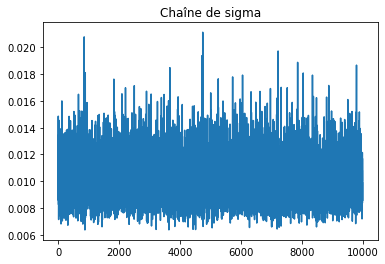

In [599]:
plt.plot(X[4])
plt.title("Chaîne de sigma");

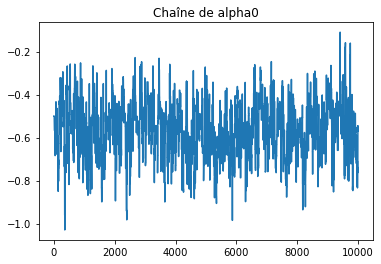

In [600]:
plt.plot(X[0])
plt.title("Chaîne de alpha0");

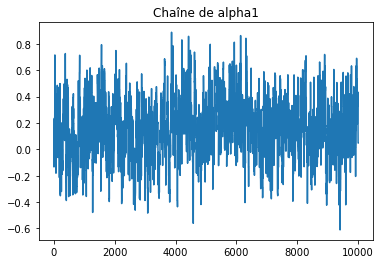

In [601]:
plt.plot(X[1])
plt.title("Chaîne de alpha1");

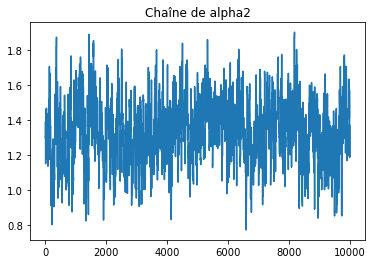

In [602]:
plt.plot(X[2])
plt.title("Chaîne de alpha2");

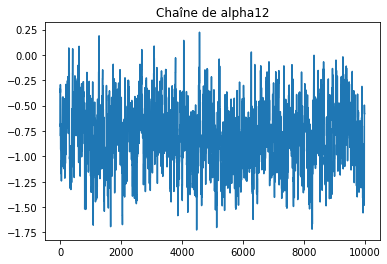

In [603]:
plt.plot(X[3])
plt.title("Chaîne de alpha12");

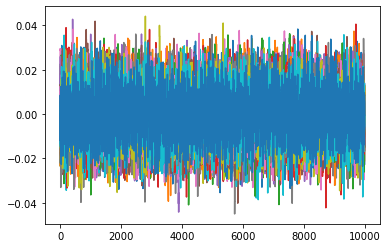

In [604]:
for i in range(K):
    plt.plot(Xb[i])

In [605]:
alpha0,alpha1,alpha2,alpha12,sigma=np.mean(X,axis=1)
print(f"alpha0 a posteriori: {np.round(alpha0,3)}")
print(f"alpha1 a posteriori: {np.round(alpha1,3)}")
print(f"alpha2 a posteriori: {np.round(alpha2,3)}")
print(f"alpha12 a posteriori: {np.round(alpha12,3)}")
print(f"sigma a posteriori: {np.round(sigma,3)}")

alpha0 a posteriori: -0.57
alpha1 a posteriori: 0.164
alpha2 a posteriori: 1.331
alpha12 a posteriori: -0.796
sigma a posteriori: 0.01


In [616]:
print(f"variance alpha0 a posteriori: {np.round(np.var(X[0]),3)}")
print(f"variance alpha1 a posteriori: {np.round(np.var(X[1]),3)}")
print(f"variance alpha2 a posteriori: {np.round(np.var(X[2]),3)}")
print(f"variance alpha12 a posteriori: {np.round(np.var(X[3]),3)}")
print(f"variance sigma a posteriori: {np.round(np.var(X[4]),8)}")

variance alpha0 a posteriori: 0.017
variance alpha1 a posteriori: 0.049
variance alpha2 a posteriori: 0.032
variance alpha12 a posteriori: 0.09
variance sigma a posteriori: 2.7e-06


In [606]:
g1=sigm(alpha0)
g2=sigm(alpha0+alpha1)
g3=sigm(alpha0+alpha2)
g4=sigm(alpha0+alpha1+alpha2+alpha12)

Voici les probabilités de germinations (obtenus à partir des moyennes a posteriori des paramètres) pour les 4 groupes identifiés:

In [619]:
print("Seed 75, bean    :",np.round(g1,3))
print("Seed 73,bean     :",np.round(g2,3))
print("Seed 75, cucumber:",np.round(g3,3))
print("Seed 73, cucumber:",np.round(g4,3))

Seed 75, bean    : 0.361
Seed 73,bean     : 0.4
Seed 75, cucumber: 0.682
Seed 73, cucumber: 0.532
